# 4He on Graphene: Band Structure

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import re,glob,os
import dgutils.colors as colortools
import matplotlib as mpl

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# plot style
plot_style = {'notebook':'../include/notebook.mplstyle','aps':'../include/aps.mplstyle'}
plt.style.reload_library()
plt.style.use(plot_style['aps'])
figsize = plt.rcParams['figure.figsize']

plt.rcParams['text.latex.preamble'] = f'\input{{{os.getcwd()}/../include/texheader}}'

load data

In [2]:
print(figsize)

[3.4039, 2.10373]


In [3]:
GMKG = np.loadtxt('../data/band_structure.txt', delimiter = ',')

GMKG_Length = GMKG[:, 0]
GMKG_Bands = GMKG[:, 1:]
First_band_max = np.ones(len(GMKG_Length))*np.max(GMKG[:, 1])
First_band_min = np.ones(len(GMKG_Length))*np.min(GMKG[:, 1])

In [4]:
GMKG_Length_stretched = 0*GMKG_Length

M_length = GMKG_Length[24]
K_length = GMKG_Length[32]
G_length = GMKG_Length[40]
band_M = GMKG_Bands[24]
band_K = GMKG_Bands[32]
band_G = GMKG_Bands[0]

GMKG_Length_stretched[0:25] = GMKG_Length[0:25]
GMKG_Length_stretched[25:33] = (GMKG_Length[25:33] - M_length)/(K_length-M_length)*M_length/np.sqrt(3) + M_length
GMKG_Length_stretched[33:41] = ((GMKG_Length[33:41] - K_length)/(G_length-K_length)*M_length/np.sqrt(3)*2 
                                 + GMKG_Length_stretched[32])

In [5]:
g1 = [2*np.pi, 0]
g2 = [1*np.pi, np.sqrt(3)*np.pi]
g3 = [-1*np.pi, np.sqrt(3)*np.pi]
g4 = [3*np.pi, np.sqrt(3)*np.pi]
g5 = [0*np.pi, 2*np.sqrt(3)*np.pi]
g6 = [-3*np.pi, np.sqrt(3)*np.pi]

def bs_cosines(x, y, a, b):
    why = 4/(2*np.sqrt(3))
    r = [x*why, y*why]
    first_set = a*(np.cos(np.dot(r, g1)/2)+np.cos(np.dot(r, g2)/2)+np.cos(np.dot(r, g3)/2))
    second_set = b*(np.cos(np.dot(r, g4)/2)+np.cos(np.dot(r, g5)/2)+np.cos(np.dot(r, g6)/2))
    combined = first_set + second_set
    return  combined

def bs_mesh(X, Y, a, b):
    band_structure = np.zeros((len(X), len(Y)))
    for ix in range(len(X)): 
        for iy in range(len(Y)):
            band_structure[ix, iy] = bs_cosines(X[ix], Y[iy], a, b)
            
    return band_structure

In [15]:
print(band_M[0]-band_G[0])
print(band_K[0]-band_G[0])

10.565054096756
13.11216067766199


In [6]:
X = np.linspace(-2,2,100)
Y = np.linspace(-2,2,100)
a = -2.91381348
b = 0.27255

fit_0 = bs_cosines(0, 0, a, b)
fit_s = bs_cosines(0, 1, a, b)
fit_m = bs_cosines(1/np.sqrt(3), 1, a, b)
print(fit_s-fit_0)
print(fit_m-fit_0)

10.56505392
13.11216066


In [7]:
GMKG_cosines = 0*GMKG_Length

for i in range(25):
    GMKG_cosines[i] = bs_cosines(0, i/25, a, b)
    
for i in range(25, 33):
    GMKG_cosines[i] = bs_cosines((i-24)/np.sqrt(3)/(33-25), 1, a, b)
    
for i in range(33, 41):
    GMKG_cosines[i] = bs_cosines(1/np.sqrt(3) - (i-32)/np.sqrt(3)/(41-33), 1 - (i-32)/(41-33), a, b)
    
GMKG_cosines = GMKG_cosines - np.min(GMKG_cosines) + np.min(GMKG_Bands)

Plotting

## Lowest Band for All Methods

In [8]:
def hex_to_rgb(value,transmit=None, full=False):
    '''Convert a hex color to rgb tuple.'''
    value = value.lstrip('#')
    lv = len(value)
    step = int(lv/3) 
    scale = 1.0/255.0
    if full:
        scale = 1
    col = tuple(scale*int(value[i:i+step], 16) for i in range(0, lv, step))

    if not transmit:
        return col
    else:
        return col + (transmit,)

def get_alpha_hex(value,alpha, real=False):
    '''Convert a hex color to an equivalent non-transparent version.'''

    #first we get the rgb
    rgb = hex_to_rgb(value)

    # apply the transparency
    target = [alpha*k + (0.999-alpha) for k in rgb] 

    if not real:
        return rgb_to_hex(target)
    else:
        transparent = str(hex(int(alpha*255)))[-2:]
        return value + transparent
    
def rgb_to_hex(value):
    '''Convert a rgb tuple to a hex color string.'''
    if value[0] < 1:
        scale = 255
    else:
        scale = 1
    rgb = [int(scale*k) for k in value]
    return '#%02x%02x%02x' % (rgb[0],rgb[1],rgb[2]) 

In [9]:
methods = ['Wannier','QMC','DFT','MP2']
colors = ["#d43e4e", "#abdda4", "#3288bc"]


file_names = {'Wannier':'wannierband.txt', 'QMC':'qmcband.txt', 'DFT':'dftband.txt', 'MP2':'mp2band.txt'}

col = {}
col['Wannier'] = '#58595B'
col['QMC'] = colors[0]
col['DFT'] = colors[2]
col['MP2'] = colors[1]

props = {}
props['Wannier'] = {'mfc':colortools.get_alpha_hex(col['Wannier'],0.5,real=True), 'mec':col['Wannier'], 'ms':4, 'label':'Wannier', 'marker':'^', 'mew':0.6,'zorder':-2, 'lw':0}
props['QMC'] = {'mfc':colortools.get_alpha_hex(colors[0],0.5,real=True), 'mec':colors[0], 'ms':4, 'label':'QMC', 'marker':'o', 'mew':0.6,'zorder':2, 'lw':0}
props['DFT'] = {'mfc':colortools.get_alpha_hex(colors[2],0.5,real=True), 'mec':colors[2], 'ms':4, 'label':'DFT', 'marker':'s', 'mew':0.6,'zorder':-2, 'lw':0}
props['MP2'] = {'mfc':colortools.get_alpha_hex(colors[1],0.5,real=True), 'mec':colors[1], 'ms':4, 'label':'MP2', 'marker':'D', 'mew':0.6,'zorder':-2, 'lw':0}

              
ε,k = {},{}
M,K = {},{}
t = {}
for method in methods:
    data = np.loadtxt(open(f'../data/{file_names[method]}', 'r'), delimiter=',', skiprows=0)
    k[method] = data[:,0]
    ε[method] = data[:,1]
    
    M[method] = np.where(k[method]>2.72)[0][0]
    K[method] = np.where(k[method]>4.2)[0][0]
    k[method] /= k[method][-1]
    
    t[method] = (ε[method][K[method]]-ε[method][0])/9  

In [10]:
method = 'Wannier'
aₒ = 1.42 # C-C lattice spacing in graphene
π = np.pi

# high symmetry points for the graphene BZ
Γp = np.array([0,0])
Kp = np.array([4*π/(3*np.sqrt(3)*aₒ),0])
Mp = np.array([π/(np.sqrt(3)*aₒ),π/(3*aₒ)])

E_spec = np.zeros(10*len(k[method]))
M_idx = int(k[method][M[method]]*len(E_spec))
K_idx = int(k[method][K[method]]*len(E_spec))
G_idx = len(E_spec)

k_spec = np.zeros([len(E_spec),2])
k_spec_frac = np.arange(len(E_spec))/(len(E_spec)-1)

k_spec[:M_idx,0] = np.linspace(0,Mp[0],M_idx)
k_spec[:M_idx,1] = k_spec[:M_idx,0]/np.sqrt(3)

dkx = (Kp[0]-Mp[0])/(K_idx-M_idx)
k_spec[M_idx:K_idx,0] = np.linspace(Mp[0]+dkx,Kp[0],(K_idx-M_idx))
k_spec[M_idx:K_idx,1] = -np.sqrt(3)*k_spec[M_idx:K_idx,0] + 4*π/(3*aₒ)

k_spec[K_idx:,0] = np.linspace(Kp[0],0,G_idx-K_idx) 
k_spec[K_idx:,1] = 0.0

In [11]:
def E_tb(k,εₒ,t):
    global aₒ
    a = np.sqrt(3)*aₒ
    return εₒ - 2*t*(np.cos(k[:,0]*a) + 2*np.cos(k[:,0]*a/2)*np.cos(np.sqrt(3)*a*k[:,1]/2))

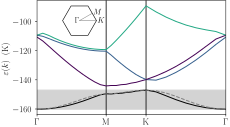

In [12]:
cmap = plt.cm.get_cmap('viridis')

colors = [cmap(i*0.3) for i in range(3)]

fig,ax = plt.subplots(figsize=figsize)

ax.axvline(GMKG_Length_stretched[24], color = 'black', linewidth = 0.8)
ax.axvline(GMKG_Length_stretched[32], color = 'black', linewidth = 0.8)

#plt.plot(GMKG_Length_stretched, First_band_max, c = 'lightgrey', lw = 0.8)
#plt.plot(GMKG_Length_stretched, First_band_min, c = 'lightgrey', lw = 0.8)
ax.fill_between(GMKG_Length_stretched, First_band_min, First_band_max, color = 'lightgrey')

ax.plot(GMKG_Length_stretched, GMKG_Bands[:, 0], c = 'black', lw = 1)
ax.plot(GMKG_Length_stretched[0:33], GMKG_Bands[0:33, 1], c = colors[0], lw = 1)
ax.plot(GMKG_Length_stretched[0:33], GMKG_Bands[0:33, 2], c = colors[1], lw = 1)
ax.plot(GMKG_Length_stretched[32:], GMKG_Bands[32:, 1], c = colors[1], lw = 1)
ax.plot(GMKG_Length_stretched[32:], GMKG_Bands[32:, 2], c = colors[0], lw = 1)
ax.plot(GMKG_Length_stretched, GMKG_Bands[:, 3], c = colors[2], lw = 1)

ax.plot(GMKG_Length_stretched, GMKG_cosines, c = 'grey', lw = 1, linestyle = "--")

ax.set_xlim(GMKG_Length_stretched[0], GMKG_Length_stretched[-1])

ax.set_xticks([GMKG_Length_stretched[0], GMKG_Length_stretched[24], GMKG_Length_stretched[32], 
            GMKG_Length_stretched[40]])
ax.set_xticklabels([r'$\Gamma$', r'M', r'K' , r'$\Gamma$'])
ax.tick_params(top=False)

ax.set_ylabel(r'$\alabel{\varepsilon(k)}{\kelvin}$')


from matplotlib.patches import RegularPolygon
# add the BZ
axbz = ax.inset_axes([0.05, 0.65, 0.35,0.35])

hexagon = RegularPolygon((0,0), numVertices=6, radius=Kp[0], edgecolor='k', facecolor='None', lw=0.6)
t2 = mpl.transforms.Affine2D().rotate_deg(-90) + axbz.transData
hexagon.set_transform(t2)

axbz.add_patch(hexagon)
axbz.set_xlim(-2,2)
axbz.set_ylim(-2,2)

axbz.plot([Γp[0],Kp[0]],[Γp[1],Kp[1]], '-', color='grey', lw=0.5, zorder=-10)
axbz.plot([Γp[0],Mp[0]],[Γp[1],Mp[1]], '-', color='grey', lw=0.5, zorder=-10)

axbz.annotate(r"$\Gamma$",zorder=-1,xy=Γp, xycoords='data',xytext=(-5, -2), textcoords='offset points', fontsize=8)
axbz.annotate(r"$K$",zorder=-1,xy=Kp, xycoords='data',xytext=(+1, -2), textcoords='offset points', fontsize=8)
axbz.annotate(r"$M$",zorder=-1,xy=Mp, xycoords='data',xytext=(+1, -1), textcoords='offset points', fontsize=8)
axbz.set_aspect('equal')
axbz.axis('off') ;

plt.savefig('../plots/band_structure.pdf', dpi=300, transparent=False) 
plt.savefig('../plots/band_structure.svg', transparent=False) 

In [23]:

# # compute the recoil energy
# λ = np.sqrt(3)*aₒ
# λ *= 1.0E-10
# E_R = ħ**2*(π)**2/(2*m_Ne*λ**2)/kB
# t = (E[K_point,0]-E[0,0])/9 * E_R

# # Kinetic energy comes form Wannier code
# K = 6.27*E_R

# # Output results
# print(f'E_R = {E_R:.2f} K')
# print(f't = {t:.3f} K')
# print(f'Kin. Energy = {K:.1f} K')

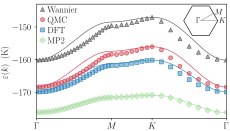

In [14]:
from matplotlib.patches import RegularPolygon

fig,ax = plt.subplots(figsize=figsize)

method = 'Wannier'
for method in methods:
    ax.plot(k[method],ε[method], **props[method])
    plt.plot(k_spec_frac,E_tb(k_spec,ε[method][0]+6*t[method],t[method]), color=col[method], lw=0.6, zorder=-10, ls='-')


ax.set_xticks([0,k[method][M[method]],k[method][K[method]],k[method][-1]])
ax.set_xticklabels([r'$\Gamma$', r'$M$', r'$K$', r'$\Gamma$'])

ax.set_ylabel(r'$\alabel{\varepsilon(k)}{\kelvin}$')
ax.set_xlim(k[method][0],k[method][-1])
ax.set_ylim(-178,-143)

#ax.annotate('(b)', xy=(-0.195,1),ha='left', va='top', xycoords='axes fraction')

ax.legend(loc=(0.01,0.61))

# add the BZ
axbz = ax.inset_axes([0.69, 0.68, 0.35,0.35])

hexagon = RegularPolygon((0,0), numVertices=6, radius=Kp[0], edgecolor='k', facecolor='None', lw=0.6)
t2 = mpl.transforms.Affine2D().rotate_deg(-90) + axbz.transData
hexagon.set_transform(t2)

axbz.add_patch(hexagon)
axbz.set_xlim(-2,2)
axbz.set_ylim(-2,2)

axbz.plot([Γp[0],Kp[0]],[Γp[1],Kp[1]], '-', color='grey', lw=0.5, zorder=-10)
axbz.plot([Γp[0],Mp[0]],[Γp[1],Mp[1]], '-', color='grey', lw=0.5, zorder=-10)

axbz.annotate(r"$\Gamma$",zorder=-1,xy=Γp, xycoords='data',xytext=(-5, -2), textcoords='offset points', fontsize=8)
axbz.annotate(r"$K$",zorder=-1,xy=Kp, xycoords='data',xytext=(+1, -2), textcoords='offset points', fontsize=8)
axbz.annotate(r"$M$",zorder=-1,xy=Mp, xycoords='data',xytext=(+1, -1), textcoords='offset points', fontsize=8)
axbz.set_aspect('equal')
axbz.axis('off') ;

plt.savefig('../plots/lowest_bands.pdf')

In [25]:
Kp

array([1.70309799, 0.        ])

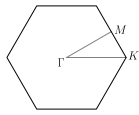

In [26]:

fig, ax = plt.subplots(1)
ax.set_aspect('equal')
hexagon = RegularPolygon((0,0), numVertices=6, radius=Kp[0], edgecolor='k', facecolor='None')
t2 = mpl.transforms.Affine2D().rotate_deg(-90) + ax.transData
hexagon.set_transform(t2)

ax.plot([Γp[0],Kp[0]],[Γp[1],Kp[1]], '-', color='grey', lw=1, zorder=-10)
ax.plot([Γp[0],Mp[0]],[Γp[1],Mp[1]], '-', color='grey', lw=1, zorder=-10)

ax.annotate(r"$\Gamma$",zorder=-1,xy=Γp, xycoords='data',xytext=(-9, -9), textcoords='offset points', fontsize=12)
ax.annotate(r"$K$",zorder=-1,xy=Kp, xycoords='data',xytext=(+2, -2), textcoords='offset points', fontsize=12)
ax.annotate(r"$M$",zorder=-1,xy=Mp, xycoords='data',xytext=(+3, -2), textcoords='offset points', fontsize=12)


ax.add_patch(hexagon);
ax.axis('off') ;
plt.autoscale(enable = True)

In [27]:
Kp

array([1.70309799, 0.        ])